In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree
import sys
import pickle
import warnings
import shutil
import os
import re

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# issue : https://stackoverflow.com/questions/42562876/opencv3-error-unable-to-stop-the-stream-inappropriate-ioctl-for-device

def convert_video_to_frames(video_file_name, video_file_path, frame_output_path):
    vidcap = cv2.VideoCapture(video_file_path)
    count = 1
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite('{0}/{1}_frame_{2}.jpg'.format(frame_output_path,video_file_name,count), image)
        count += 1
        
def plot_boundaries(img_path, x, y, width, height):
    img = cv2.imread(img_path)
    cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 2)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)
    plt.figure(figsize=(16,19))
    plt.imshow(gray)
    plt.show()

In [3]:
convert_video_to_frames('Attack_CloseUp_Day_Empty_1_2_1','data/Attack_CloseUp_Day_Empty_1_2_1.mp4','data/Attack_CloseUp_Day_Empty_1_2_1')

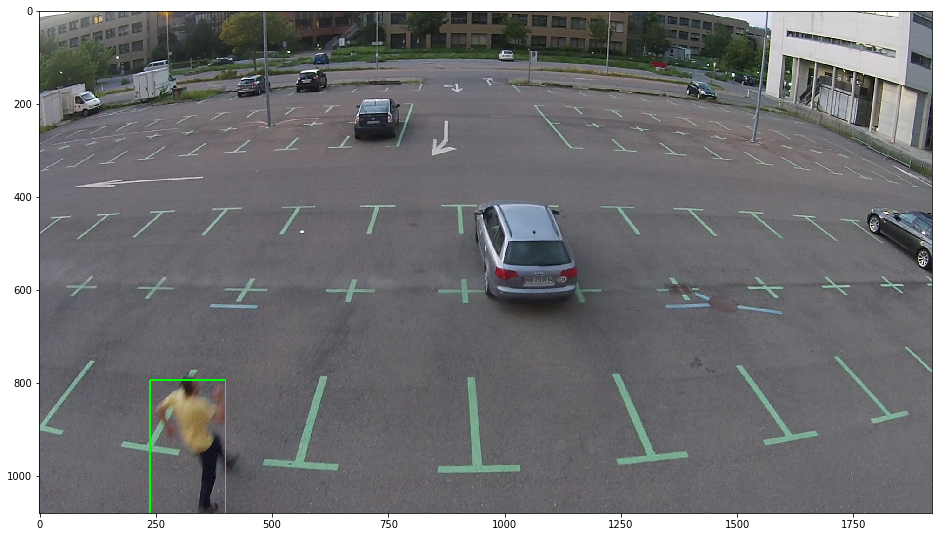

In [4]:
plot_boundaries('data/Attack_CloseUp_Day_Empty_1_2_1/Attack_CloseUp_Day_Empty_1_2_1_frame_62.jpg', 238,794,163, 286)

In [5]:
# TO DO : run for files with no person, one person and morethan one person

def get_frames_from_span(frame_dict, label):
    frames = {}
    if frame_dict:
        x = int(frame_dict['x'])
        y = int(frame_dict['y'])
        width = int(frame_dict['width'])
        height = int(frame_dict['height'])
        frame_span = frame_dict['framespan']
        
        for i in range(int(frame_span.split(':')[0]) , int(frame_span.split(':')[1])+1):
            if i not in frames:
                frames[i] = list()
            frames[i].append({'xmin':x, 'ymin':y, 'xmax':x + width, 'ymax':y + height, 'label':label})
    return frames

def parse_xgtf_ann_file(file_name, object_type): 
    master_frame_map = {}
    root = xml.etree.ElementTree.parse(file_name).getroot()
    for child in root:
        if 'data' in child.tag:
            for obj in child.getchildren()[0].getchildren():
                if 'object' in obj.tag and obj.attrib['name'] == object_type:
                    object_id = obj.attrib['id']
                    for attr in obj.getchildren():
                        if 'attribute' in attr.tag and (attr.attrib['name'] == 'box' or attr.attrib['name'] == 'obox'):
                            for bbox in attr.getchildren():
                                if 'bbox' in bbox.tag:
                                    frame_map = get_frames_from_span(bbox.attrib, object_type)
                                    # Check whether multiple persons are present in same frame
                                    if not master_frame_map:
                                        master_frame_map = frame_map
                                    else:
                                        for frame in frame_map.keys():
                                            if frame_map[frame] is not None:
                                                if frame not in master_frame_map:
                                                    master_frame_map[frame] = list()
                                                master_frame_map[frame].extend(frame_map[frame])
    return master_frame_map

In [6]:
def draw_boundaries(frame_data, video_file_name,root_folder, output_folder):
    if frame_data:
        for frame in frame_data.keys():
            img = cv2.imread('{0}/{1}_frame_{2}.jpg'.format(root_folder, video_file_name, frame))
            if not img is None:
                for ann in frame_data[frame]:
                    cv2.rectangle(img, (ann['xmin'], ann['ymin']), (ann['xmax'], ann['ymax']), (0, 255, 0), 2)
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)

                cv2.imwrite('{0}/{1}_frame_{2}.jpg'.format(output_folder, video_file_name, frame),gray)

In [7]:
frame_data = parse_xgtf_ann_file('data/Attack_CloseUp_Day_Empty_1_2_1.xgtf', 'Person')

In [8]:
draw_boundaries(frame_data, 'Attack_CloseUp_Day_Empty_1_2_1', 'data/Attack_CloseUp_Day_Empty_1_2_1', 'data/Attack_CloseUp_Day_Empty_1_2_1_ann')

In [9]:
root_folder = '../data/mini-drone-data'
train_data = '../data/mini-drone-data/DroneProtect-training-set'
train_out_data = '../data/mini-drone-data_processed/train'

test_data = '../data/mini-drone-data/DroneProtect-testing-set'
test_out_data = '../data/mini-drone-data_processed/test'

# create base folders for person image classifier
person_folder = '{0}/{1}'.format(root_folder, 'person_classification_data/person')
non_person_folder = '{0}/{1}'.format(root_folder, 'person_classification_data/non-person')
#os.mkdir('{0}/{1}'.format(root_folder, 'person_classification_data'))
os.makedirs(person_folder, exist_ok=True)
os.makedirs(non_person_folder, exist_ok=True)

annotation_file_format = '.xgtf'
object_type = 'Person'

for x in os.listdir(train_data):
    if '.mp4' in x:
        video_file_path = '{0}/{1}'.format(train_data, x)
        video_file_name = x.split('.')[0]
        print('Processing {0}....'.format(x))
        # creates folder for frames
        print('creating frames....')
        frame_out_folder = '{0}/{1}'.format(train_out_data, video_file_name) 
        os.makedirs(frame_out_folder, exist_ok=True)
        
        # convert video to frames and write to output folder
        convert_video_to_frames(video_file_name, video_file_path, frame_out_folder)
        
        # read xml based annotation file and write as python dict object
        print('creating annotation object....')
        ann_file = '{0}/{1}{2}'.format(train_data, video_file_name, annotation_file_format)
        frame_data = parse_xgtf_ann_file(ann_file, object_type)
        filehandler = open("{0}/{1}_ann.obj".format(train_out_data, video_file_name),"wb")
        pickle.dump(frame_data, filehandler)
        
        # create training data for object classification
        print('training data preparation....')
        person_frames = set(frame_data.keys())
        print(person_frames)
        for img in os.listdir(frame_out_folder):
            if '.jpg' in img:
                frame_number_search = re.search('.*_frame_(\d+).jpg', img, re.IGNORECASE)
                if frame_number_search:
                    frame_number = int(frame_number_search.group(1))
                    file_path = '{0}/{1}'.format(frame_out_folder, img)
                    if frame_number in person_frames:
                        shutil.copy2(file_path, person_folder)
                    else:
                        shutil.copy2(file_path, non_person_folder)

Processing Falling_Static_Day_Half_0_1_1.mp4....
creating frames....
creating annotation object....
training data preparation....
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

Processing Suspicious_CloseUp_Night_Empty_1_3_1.mp4....
creating frames....
creating annotation object....
training data preparation....
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 

Processing Normal_Static_Day_Half_0_2_1.mp4....
creating frames....
creating annotation object....
training data preparation....
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196

Processing StealingPedestrian_CloseUp_Day_Half_0_2_1.mp4....
creating frames....
creating annotation object....
training data preparation....
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 

Processing StealingPedestrian_CloseUp_Day_Half_0_2_2.mp4....
creating frames....
creating annotation object....
training data preparation....
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 